In [ ]:
# Reference https://github.com/jancervenka/turbofan_failure

# Data Preparation and Feature Engineering

In [ ]:
import joblib
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from itertools import chain

from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import median_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

pd.set_option('max_columns', 120)

%matplotlib inline

LAGS = [5, 10, 20, 30, 40]

In [ ]:
def mean_prediction_score(RUL_real, RUL_pred):
    d = RUL_pred - RUL_real
    
    return (np.sum(np.exp(d[d >= 0] / 13) - 1) +
            np.sum(np.exp(-1 * d[d < 0] / 10) - 1)) / len(RUL_real)

In [ ]:
def add_total_cycles(data):
    data = data[list(range(0, 26))].rename(columns= {0: 'unit', 1: 'cycle'})
    total_cycles = data.groupby(['unit']).agg({'cycle': 'max'}).reset_index()
    total_cycles = total_cycles.rename(columns={'cycle': 'total_cycles'})
    return data.merge(total_cycles, how='left', left_on='unit', right_on='unit')

def load_train_data(data_name):
    data = pd.read_csv('train_{}.txt'.format(data_name), sep=' ', header=None)
    data = add_total_cycles(data)
    data['RUL'] = data.apply(lambda r: int(r['total_cycles'] - r['cycle']), axis=1)
    
    return data

def load_test_data(data_name):
    data = pd.read_csv('test_{}.txt'.format(data_name), sep=' ', header=None)
    data = add_total_cycles(data)
    
    rul = pd.read_csv('RUL_{}.txt'.format(data_name), sep=' ', header=None)
    rul = rul[list(range(0, 1))]
    rul['unit'] = list(range(1, len(rul) + 1))
    rul = rul.rename(columns = {0: 'RUL'})
    
    data = data.merge(rul, how='left', left_on='unit', right_on='unit')
    
    data['total_cycles'] = data.apply(lambda r: int(r['total_cycles'] + r['RUL']), axis=1)
    data['RUL'] = data.apply(lambda r: int(r['total_cycles'] - r['cycle']), axis=1)
    
    return data

In [ ]:
def get_row_lags(unit_data, i, feature_cols):
    periods = LAGS
    ix = [i] + [i - period for period in periods]
    return unit_data.loc[ix, feature_cols].values, unit_data.loc[i, 'RUL']

def get_lagged_unit_data(data, unit, feature_cols):
    periods = LAGS
    unit_data = data[data['unit'] == unit].sort_values(
        by=['cycle'], ascending=True).reset_index(drop=True)

    lagged_unit_data = [get_row_lags(unit_data, i, feature_cols)
                        for i in range(max(periods), len(unit_data))]
    
    return lagged_unit_data

def get_lagged_data(data, feature_cols):
    
    lagged_data = chain(*[get_lagged_unit_data(data, unit, feature_cols)
                          for unit in data['unit'].unique()])
    
    measurement, rul = zip(*list(lagged_data))
    return np.array(measurement), np.array(rul)

In [ ]:
dataset_name = 'FD004'

feature_cols = range(2, 26)
col_dict = {c: 'f{}'.format(c) for c in feature_cols}
feature_cols = [v for _, v in col_dict.items()]

train = load_train_data(dataset_name).rename(columns=col_dict)
test = load_test_data(dataset_name).rename(columns=col_dict)

scaler = StandardScaler()
pca = PCA(n_components=len(feature_cols))

train.loc[:, feature_cols] = scaler.fit_transform(train.loc[:, feature_cols])
train.loc[:, feature_cols] = pca.fit_transform(train.loc[:, feature_cols])

test.loc[:, feature_cols] = scaler.transform(test.loc[:, feature_cols])
test.loc[:, feature_cols] = pca.transform(test.loc[:, feature_cols])

x_train, y_train = get_lagged_data(train, feature_cols)
x_test, y_test = get_lagged_data(test, feature_cols)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train)

# LSTM Regressor

In [ ]:
def neural_factory(network_depth, dense_size, dropout_rate, reg_lambda, learning_rate):

    kernel_initializer = 'glorot_uniform'
    input_layer = l = Input(shape=x_train.shape[1:], name='components')
    
    l = LSTM(64, name='lstm', kernel_regularizer=L1L2(reg_lambda, reg_lambda))(l)
    l = Dropout(dropout_rate, name='dropout_lstm')(l)
    
    for i in range(max(1, network_depth)):
        l = Dense(dense_size,
                  activation='relu',
                  name='hidden_{}'.format(i),
                  kernel_initializer=kernel_initializer,
                  kernel_regularizer=L1L2(reg_lambda, reg_lambda))(l)
        l = Dropout(dropout_rate, name='dropout_{}'.format(i))(l)
   
    rul_layer = Dense(1, name='rul_prediction')(l)
    model = Model(inputs=[input_layer], outputs=[rul_layer], name='rlu_estimator')
    opt = Adam(lr=learning_rate)
    model.compile(loss='mse', optimizer=opt, metrics=['mae'])
        
    return model

def random_search(x_train, y_train, x_val, y_val, batch_size=32, epochs=2):
    
    param_grid = {
      'network_depth': [1, 2, 3],
      'dense_size': [32, 64, 128],
      'dropout_rate': [0.1, 0.3],
      'reg_lambda': [0.1, 0.2],
      'learning_rate': [0.001, 0.01]}

    model = KerasRegressor(build_fn=neural_factory, verbose=0)
    rs_keras = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
        scoring='neg_mean_squared_error', n_iter=5, cv=2, n_jobs=1, verbose=1)

    rs_keras.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

    for param, value in rs_keras.best_params_.items():
        print('{}: {}'.format(param, value))                 
    
    return rs_keras.best_params_

In [ ]:
best_params = random_search(x_train, y_train, x_val, y_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/

reg_lambda: 0.2
network_depth: 3
learning_rate: 0.001
dropout_rate: 0.1
dense_size: 32


In [ ]:
best_params = {
    'reg_lambda': 0.6,
    'network_depth': 3,
    'learning_rate': 0.01,
    'dropout_rate': 0.5,
    'dense_size': 64}

In [ ]:
def annealing(epoch):
    lr = 0.01
    annealing_start = 5
    return lr if epoch < annealing_start else lr * np.exp(0.1 * (annealing_start - epoch))

model_nn = neural_factory(**best_params)
callbacks = [
    EarlyStopping(patience=8, verbose=1),
    LearningRateScheduler(annealing, verbose=1)]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_nn.summary()

Model: "rlu_estimator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 components (InputLayer)     [(None, 6, 24)]           0         
                                                                 
 lstm (LSTM)                 (None, 64)                22784     
                                                                 
 dropout_lstm (Dropout)      (None, 64)                0         
                                                                 
 hidden_0 (Dense)            (None, 64)                4160      
                                                                 
 dropout_0 (Dropout)         (None, 64)                0         
                                                                 
 hidden_1 (Dense)            (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)              

In [ ]:
model_nn_hist = model_nn.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32,
    epochs=25, callbacks=callbacks, verbose=1)
# model_nn.save('models/lstm.h5')


Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/25
1203/1203 [==============================] - 12s 8ms/step - loss: 5128.7461 - mae: 48.4141 - val_loss: 3986.1765 - val_mae: 45.1765 - lr: 0.0100

Epoch 00002: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/25
1203/1203 [==============================] - 9s 7ms/step - loss: 4513.9644 - mae: 46.4441 - val_loss: 3446.6328 - val_mae: 40.5064 - lr: 0.0100

Epoch 00003: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/25
1203/1203 [==============================] - 9s 7ms/step - loss: 4232.8960 - mae: 44.8205 - val_loss: 3425.2747 - val_mae: 40.7964 - lr: 0.0100

Epoch 00004: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/25
1203/1203 [==============================] - 9s 7ms/step - loss: 4141.1943 - mae: 44.3295 - val_loss: 3431.2888 - val_mae: 39.9335 - lr: 0.0100

Epoch 00005: LearningRateScheduler setting learning rate to 0.01.
Epoch 5/25
1203/1203 [======================

In [ ]:
def evaluate_model(model, x, y):
    y_pred = model.predict(x).reshape(-1)
    print('Mean Prediction Score:', mean_prediction_score(y, y_pred))
    print('Mean squared Error:', mean_squared_error(y, y_pred))
    print('Median absolute error:', median_absolute_error(y, y_pred))
    print('R2:', r2_score(y, y_pred))

In [ ]:
evaluate_model(model_nn, x_val, y_val)

Mean Prediction Score: 162628000989.59647
Mean squared Error: 2430.9477080284532
Median absolute error: 26.088760375976562
R2: 0.6322208092019226


In [ ]:
evaluate_model(model_nn, x_train, y_train)

Mean Prediction Score: 71564425314.32584
Mean squared Error: 2352.4484792355734
Median absolute error: 25.282833099365234
R2: 0.643123214597584


In [ ]:
evaluate_model(model_nn, x_test, y_test)

Mean Prediction Score: 502841128064.9013
Mean squared Error: 4582.959042212867
Median absolute error: 36.03767395019531
R2: 0.4093557520957277


In [ ]:
model_nn_hist.history

{'loss': [5128.74609375,
  4513.96435546875,
  4232.89599609375,
  4141.1943359375,
  4021.272216796875,
  3956.015625,
  3797.165771484375,
  3740.667724609375,
  3574.70849609375,
  3496.899169921875,
  3407.37841796875,
  3406.3896484375,
  3361.919921875,
  3300.15869140625,
  3263.22216796875,
  3197.30224609375,
  3193.536865234375,
  3172.753173828125,
  3134.339599609375,
  3127.361328125,
  3073.3935546875,
  3078.00146484375,
  3065.813720703125,
  3033.363037109375,
  3031.61328125],
 'lr': [0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.009048374,
  0.008187308,
  0.007408182,
  0.0067032003,
  0.0060653067,
  0.0054881163,
  0.004965853,
  0.0044932896,
  0.0040656966,
  0.0036787945,
  0.0033287108,
  0.0030119421,
  0.0027253178,
  0.0024659697,
  0.0022313015,
  0.002018965,
  0.0018268352,
  0.0016529888,
  0.0014956862],
 'mae': [48.41407012939453,
  46.444122314453125,
  44.8205451965332,
  44.32951354980469,
  43.858726501464844,
  43.30416488647461,
  42.1560516

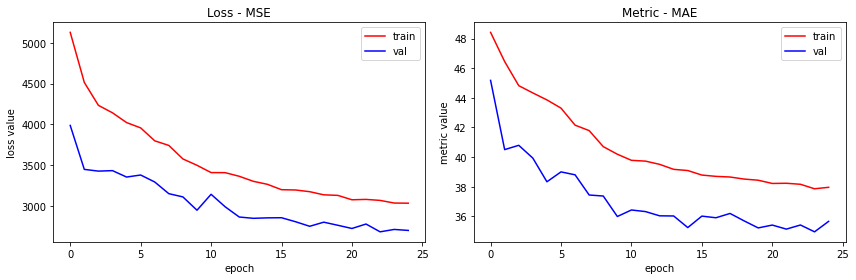

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(model_nn_hist.history['loss'], 'r', label='train')
ax[0].plot(model_nn_hist.history['val_loss'], 'b', label='val')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss value')
ax[0].set_title('Loss - MSE')
ax[0].legend()

ax[1].plot(model_nn_hist.history['mae'], 'r', label='train')
ax[1].plot(model_nn_hist.history['val_mae'], 'b', label='val')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('metric value')
ax[1].set_title('Metric - MAE')
ax[1].legend()

plt.tight_layout()
#plt.savefig('img/lstm_history.svg')
plt.show()

# Support Vector Machine

In [ ]:
x_train_svr, y_train_svr = train[feature_cols], train['RUL']
x_test_svr, y_test_svr = test[feature_cols], test['RUL']

model_svr = SVR()
model_svr.fit(x_train_svr, y_train_svr)
# joblib.dump(m, 'models/svr.pickle')

SVR()

In [ ]:
evaluate_model(model_svr, x_test_svr, y_test_svr)

Mean Prediction Score: 164912304965477.47
Mean squared Error: 9943.116916110303
Median absolute error: 52.94577872602333
R2: -0.17048032814934255


In [ ]:
evaluate_model(model_svr, x_train_svr, y_train_svr)

Mean Prediction Score: 135645746912961.83
Mean squared Error: 5894.394025842888
Median absolute error: 45.239654396519825
R2: 0.26876956044772526
